Using device: cuda
L shape: torch.Size([10000, 10000]), L device: cuda:0


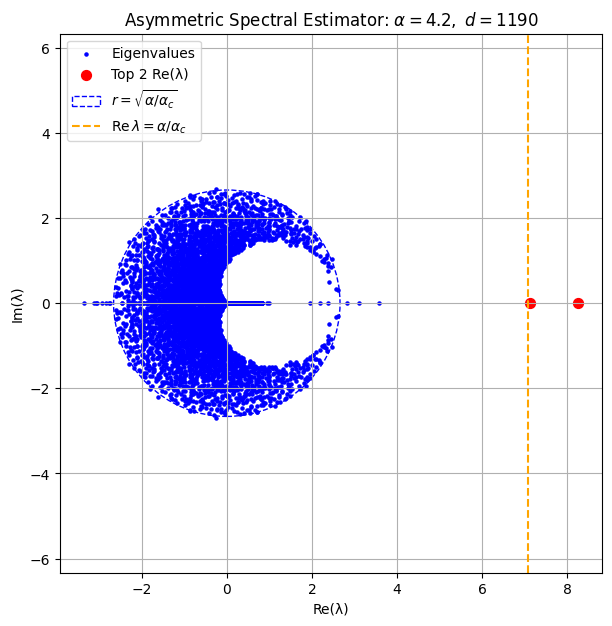

In [ ]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# Config
n = 5000               # number of samples
p = 2                  # subspace dimension
alpha = 4.2
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Input matrix X ∈ ℝ^{n×d}
X = torch.randn(n, d, device=device) / np.sqrt(d)

# Signal subspace W* and observations Z = XW*
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2  # link function

# Preprocessing G(y) ∈ ℝ^{n×p×p} using Bessel-based formulation
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1 = besselk(1, abs_y)
K0 = besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0  # numerical stability

# Construct G(y): per-sample 2×2 symmetric block
G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Spectral matrix L ∈ ℝ^{(np)×(np)} for ASE
XXT = X @ X.T                      # shape: (n, n)
XXT.fill_diagonal_(0.0)            # remove diagonal terms
A = XXT[:, :, None, None]          # shape: (n, n, 1, 1)
G_broadcast = G_y[None, :, :, :]   # shape: (1, n, p, p)
L_blocks = A * G_broadcast         # shape: (n, n, p, p)
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)
print(f"L shape: {L.shape}, L device: {L.device}")

# Eigenvalues of L
eigvals = torch.linalg.eigvals(L)
eigvals_np = eigvals.detach().cpu().numpy()
eigvals_real = eigvals_np.real

# Top-2 eigenvalues by real part
top2_idx = np.argsort(eigvals_real)[-2:]
top2_vals = eigvals_np[top2_idx]

# Spectrum visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=5, color='blue', label='Eigenvalues')
plt.scatter(top2_vals.real, top2_vals.imag, color='red', s=50, label='Top 2 Re(λ)')

# Theoretical spectral radius and threshold
r = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c
circle = plt.Circle((0, 0), r, color='blue', fill=False, linestyle='--',
                    label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--',
            label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')

# Axis and figure settings
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha},\ d = {d}$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


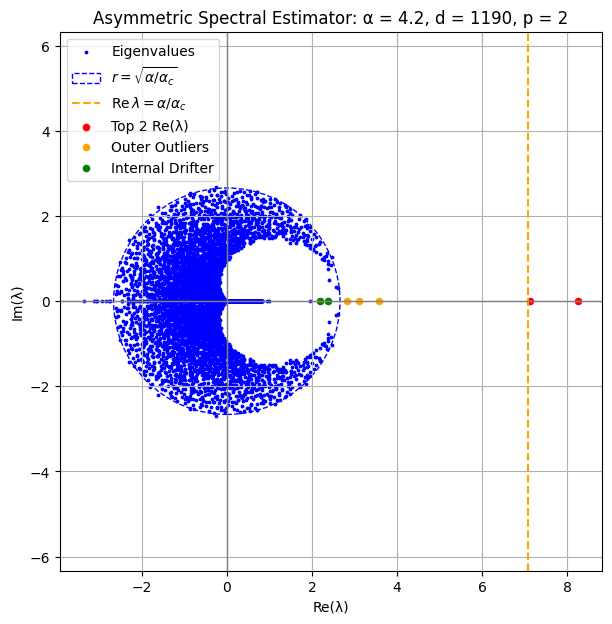

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd


# Overlap computation (projection onto W_star)
def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')      # orthonormalize W_star
    X_cpu = X.cpu().numpy().T                    # shape: (d, n)

    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]              # shape: (n*p,)
        V = v_hat.reshape(-1, 2)                # shape: (n, 2)
        U = X_cpu @ V                           # shape: (d, 2)
        for j in range(2):
            u = U[:, j]
            u_hat = u / norm(u)
            q = norm(W_orth.T @ u_hat) ** 2     # squared projection norm
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results


# Given variables
# - L: spectral matrix (torch.complex)
# - alpha, alpha_c: hyperparameters
# - W_star: ground-truth signal subspace, shape (d×2)
# - X: input matrix, shape (n×d)

eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()
d = W_star_np.shape[0]

R = np.sqrt(alpha / alpha_c)       # theoretical spectral radius
thresh_ext = alpha / alpha_c       # external outlier threshold

# Eigenvalue classification
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# Top-10 by real part
top10_real_idx = np.argsort(real_parts)[-10:]
top10_real_vals = eigvals_real_only[top10_real_idx]

# Red: top-2 eigenvalues
red_vals = top10_real_vals[-2:]
rest_vals = top10_real_vals[:-2]

# Orange: external outliers, Green candidates: inside R
orange_vals, green_candidates = [], []
for val in rest_vals:
    if R < val.real < thresh_ext:
        orange_vals.append(val)
    elif val.real < R:
        green_candidates.append(val)


# Green points: inside R, on real axis, top-2 Re
green_vals = []
inside_real_mask = np.logical_and(
    np.abs(eigvals_np) <= R,
    np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
)
eigvals_real_inside = eigvals_np[inside_real_mask]

if eigvals_real_inside.size >= 2:
    top2_idx = np.argsort(eigvals_real_inside.real)[-2:]
    green_vals = [eigvals_real_inside[i] for i in top2_idx]
elif eigvals_real_inside.size == 1:
    green_vals = [eigvals_real_inside[0]]


# Visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")

# theoretical radius and threshold
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False,
                    label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--",
            label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# highlight red, orange, and green points
plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals],
            color="red", s=20, label="Top 2 Re(λ)")
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals],
            color="orange", s=20, label="Outer Outliers")

if len(green_vals) > 0:
    plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals],
                color="green", s=20, label="Internal Drifter")

# axis setup
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


In [ ]:

# overlap
results_red = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X)
results_orange = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, orange_vals, "Orange", X)
results_green = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X)

# outcomes
df_overlap = pd.DataFrame(results_red + results_orange + results_green,
                          columns=["Label", "Eigenvalue", "Overlap_q"])
df_overlap = df_overlap.sort_values("Overlap_q", ascending=False).reset_index(drop=True)

print(df_overlap)


        Label          Eigenvalue  Overlap_q
0      Red1-1  7.131417+0.000000j   0.354454
1      Red1-2  7.131417+0.000000j   0.354454
2      Red2-1  8.241753+0.000000j   0.352663
3      Red2-2  8.241753+0.000000j   0.352663
4   Orange3-2  3.583457+0.000000j   0.001802
5   Orange3-1  3.583457+0.000000j   0.001802
6   Orange2-1  3.105779+0.000000j   0.001270
7   Orange2-2  3.105779+0.000000j   0.001270
8    Green1-1  2.197925+0.000000j   0.000922
9    Green1-2  2.197925+0.000000j   0.000922
10   Green2-2  2.373289+0.000000j   0.000695
11   Green2-1  2.373289+0.000000j   0.000695
12  Orange1-2  2.824831+0.000000j   0.000673
13  Orange1-1  2.824831+0.000000j   0.000673


In [ ]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from itertools import combinations
from scipy.linalg import qr

def rank2_overlap_from_labels(W_star, eigvals_np, eigvecs_np, df_result, X):
    """Compute rank-2 overlaps for all labeled eigenvector pairs."""
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')       # orthonormalize W_star, shape (d, 2)
    X_cpu = X.cpu().numpy().T                     # shape (d, n)

    v_map = {}  # Label → single-direction eigenvector

    # Map each labeled eigenvector to its corresponding direction
    for row in df_result.itertuples():
        label = row.Label
        val = row.Eigenvalue
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]                # shape: (n*p,)
        V = v_hat.reshape(-1, 2)                  # reshape: (n, 2)
        j = 0 if '1' in label[-3:] else 1         # pick 1st or 2nd direction
        v_map[label] = V[:, j]

    # Compute rank-2 overlaps for all unique vector pairs
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])     # project onto feature space, shape (d, 2)
        U, _ = qr(U, mode='economic')             # orthonormalize U
        q = norm(W_orth.T @ U, ord='fro')**2      # squared Frobenius norm
        results.append((f"{id1} + {id2}", q))

    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"]) \
             .sort_values("Rank2_Overlap_q", ascending=False) \
             .reset_index(drop=True)

# Required variables:
# - W_star_np: ground-truth subspace, shape (d, 2)
# - eigvals_np, eigvecs_np: eigenvalues & eigenvectors from torch.linalg.eig
# - df_result: DataFrame with ["Label", "Eigenvalue", "Overlap_q"]
# - X: input matrix, shape (n, d)

df_rank2 = rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_overlap, X)

pd.set_option("display.max_rows", None)
print(df_rank2)


               ComboLabel  Rank2_Overlap_q
0         Red1-2 + Red2-2         0.707116
1         Red1-1 + Red2-2         0.707116
2         Red1-1 + Red2-1         0.707116
3         Red1-2 + Red2-1         0.707116
4         Red2-1 + Red2-2         0.680684
5      Red1-2 + Orange3-2         0.357913
6      Red1-1 + Orange3-2         0.357913
7      Red1-1 + Orange3-1         0.357913
8      Red1-2 + Orange3-1         0.357913
9      Red1-2 + Orange1-1         0.357225
10     Red1-2 + Orange1-2         0.357225
11     Red1-1 + Orange1-2         0.357225
12     Red1-1 + Orange1-1         0.357225
13     Red2-1 + Orange2-1         0.356631
14     Red2-1 + Orange2-2         0.356631
15     Red2-2 + Orange2-1         0.356631
16     Red2-2 + Orange2-2         0.356631
17     Red2-2 + Orange3-1         0.355965
18     Red2-2 + Orange3-2         0.355965
19     Red2-1 + Orange3-2         0.355965
20     Red2-1 + Orange3-1         0.355965
21     Red1-2 + Orange2-1         0.355922
22     Red1

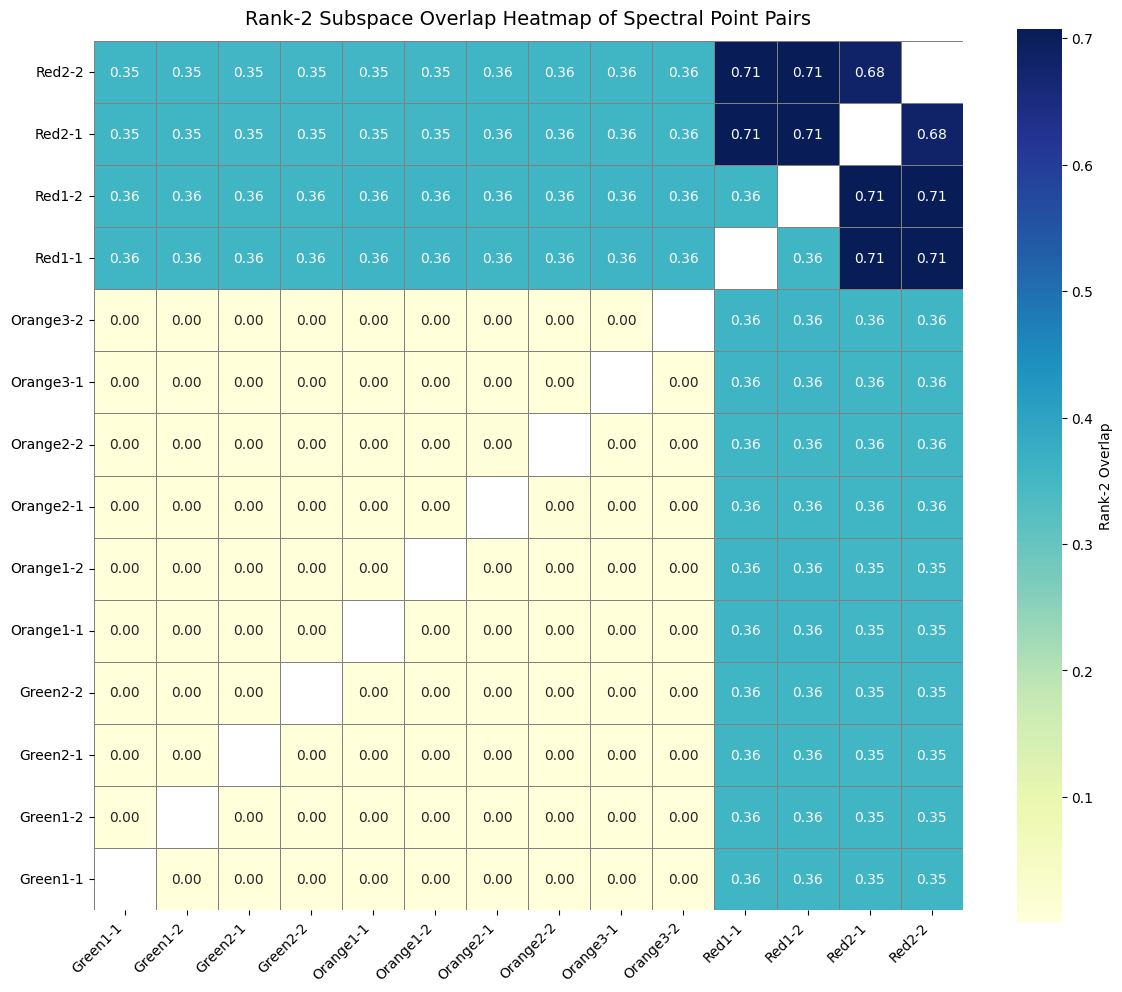

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle



# Extract unique point labels
all_labels = sorted(set(sum([label.split(' + ') for label in df_rank2['ComboLabel']], [])))

# Initialize symmetric matrix
heatmap_matrix = pd.DataFrame(np.nan, index=all_labels, columns=all_labels)

# Fill matrix with overlap scores
for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']

# Set diagonal to NaN (omit self-combinations)
np.fill_diagonal(heatmap_matrix.values, np.nan)

# Select top-5 combinations
top5 = df_rank2.nlargest(5, 'Rank2_Overlap_q')

# Draw heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    heatmap_matrix,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    square=True,
    cbar_kws={'label': 'Rank-2 Overlap'},
    linewidths=0.5,
    linecolor='gray'
)

plt.title("Rank-2 Subspace Overlap Heatmap of Spectral Point Pairs", fontsize=14, pad=12)

# Axis label formatting
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
ax.invert_yaxis()  # reverse y-axis for conventional heatmap layout

plt.tight_layout()
plt.show()
